In [1]:
import pandas as pd
df=pd.read_csv("imgs.txt", header=0, delimiter=r"\s+")

In [2]:
print(df.shape)
print(type(df.iloc[3][5]))

(202599, 41)
<class 'numpy.int64'>


In [3]:
x1=[]
x2=[]
for i in range (0,df.shape[0]):
    if df.iloc[i].Black_Hair==1:
        x1.append(df.iloc[i].imgid) 
    if df.iloc[i].Blond_Hair==1:
        x2.append(df.iloc[i].imgid) 

In [160]:
print(list(df.columns))
print(len(x1))
print(len(x2))

['imgid', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
48472
29983


In [5]:
import os
import cv2
p="H:\JupyterGod\celeba\celeba\images"
black=[]
blond=[]
size=64,64
for i in range(0,2000):
    n=cv2.imread(os.path.join(p,x1[i]))
    n=cv2.resize(n,size)
    black.append(n)
    n=cv2.imread(os.path.join(p,x2[i]))
    n=cv2.resize(n,size)
    blond.append(n)

In [6]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(cv2.cvtColor(np.array(blond[0]), cv2.COLOR_BGR2RGB))

In [7]:
import keras
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

Using TensorFlow backend.


In [8]:
def build_discriminator(img_shape,df=64):

        def d_layer(layer_input, filters, f_size=4, normalization=True):
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            return d
        img = Input(shape=img_shape)
        d1 = d_layer(img, df, normalization=False)
        d2 = d_layer(d1, df*2)
        d3 = d_layer(d2, df*4)
        d4 = d_layer(d3, df*8)
        output = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)
        return Model(img, output)
img_shape=(64,64,3)
patch_size=(4,4,1)
build_discriminator(img_shape).summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         524544    
_________________________________________________________________
leak

In [14]:
def build_generator(img_shape,gf=32):
        def conv2d(layer_input, filters, f_size=4):
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = Concatenate()([u, skip_input])
            return u

        d0 = Input(shape=img_shape)

        d1 = conv2d(d0, gf)
        d2 = conv2d(d1, gf*2)
        d3 = conv2d(d2, gf*4)
        d4 = conv2d(d3, gf*8)

        u1 = deconv2d(d4, d3, gf*4)
        u2 = deconv2d(u1, d2, gf*2)
        u3 = deconv2d(u2, d1, gf)
        u4 = UpSampling2D(size=2)(u3)
        output_img = Conv2D(3, kernel_size=4, strides=1, padding='same', activation='tanh')(u4)

        return Model(d0, output_img)
build_generator(img_shape).summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 32, 32, 32)   1568        input_9[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_25 (LeakyReLU)      (None, 32, 32, 32)   0           conv2d_40[0][0]                  
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 16, 16, 64)   32832       leaky_re_lu_25[0][0]             
__________________________________________________________________________________________________
leaky_re_l

In [21]:
optimizer = Adam(0.0002, 0.5)
d_A = build_discriminator(img_shape)
d_B = build_discriminator(img_shape)
d_A.compile(loss='mse',optimizer=optimizer,metrics=['accuracy'])
d_B.compile(loss='mse',optimizer=optimizer,metrics=['accuracy'])
g_AB = build_generator(img_shape)
g_BA = build_generator(img_shape)
img_A = Input(shape=img_shape)
img_B = Input(shape=img_shape)
fake_B = g_AB(img_A)
fake_A = g_BA(img_B)
reconstr_A = g_BA(fake_B)
reconstr_B = g_AB(fake_A)
img_A_id = g_BA(img_A)
img_B_id = g_AB(img_B)
d_A.trainable = False
d_B.trainable = False
valid_A = d_A(fake_A)
valid_B = d_B(fake_B)
model = Model(inputs=[img_A, img_B],outputs=[valid_A, valid_B,reconstr_A, reconstr_B,img_A_id, img_B_id ])
model.compile(loss=['mse', 'mse','mae', 'mae','mae', 'mae'],
                      loss_weights=[1,1,10,10,1,1],
                      optimizer=optimizer,metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
input_32 (InputLayer)           (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
model_27 (Model)                (None, 64, 64, 3)    1545411     input_33[0][0]                   
                                                                 model_26[1][0]                   
                                                                 input_32[0][0]                   
__________________________________________________________________________________________________
model_26 (

In [22]:
count=1
Black=(np.array(black).astype('float32'))/127.5-1
Blond=(np.array(blond).astype('float32'))/127.5-1
valid = np.ones((2000,) + patch_size)
fake = np.zeros((2000,) + patch_size)

In [23]:

def train(epochs):
    global count
    global d_A,d_B,g_AB,g_BA,model
    for epoch in range(epochs):
        print("________________________________________________________EPOCH: ", count)
        fake_B = g_AB.predict(Black)
        fake_A = g_BA.predict(Blond)

        # Train the discriminators (original images = real / translated = Fake)
        dA_loss_real = d_A.fit(x=Black,y=valid,batch_size=32,epochs=3)
        dA_loss_fake = d_A.fit(x=fake_A,y=fake,batch_size=32,epochs=1)
        dA_loss = 0.5 * np.add(dA_loss_real.history['loss'][-1], dA_loss_fake.history['loss'][-1])

        dB_loss_real = d_B.fit(x=Blond,y=valid,batch_size=32,epochs=3)
        dB_loss_fake = d_B.fit(x=fake_B,y=fake,batch_size=32,epochs=1)
        dB_loss = 0.5 * np.add(dB_loss_real.history['loss'][-1], dB_loss_fake.history['loss'][-1])

        # Total disciminator loss
        d_loss = 0.5 * np.add(dA_loss, dB_loss)
        g_loss = model.fit([Black,Blond],[valid, valid,Black,Blond,Black,Blond],batch_size=32,epochs=1)
        print(d_loss,g_loss.history['loss'][-1])
        count=count+1
               
                

In [24]:
train(1)

________________________________________________________EPOCH:  1
Epoch 1/3
2000/2000 [==============================] - 49s 25ms/step - loss: 0.0700 - acc: 0.9432
Epoch 2/3
2000/2000 [==============================] - 47s 24ms/step - loss: 0.0149 - acc: 0.9999
Epoch 3/3
2000/2000 [==============================] - 48s 24ms/step - loss: 0.0138 - acc: 1.0000
Epoch 1/1
2000/2000 [==============================] - 48s 24ms/step - loss: 0.0041 - acc: 0.9988
Epoch 1/3
2000/2000 [==============================] - 48s 24ms/step - loss: 0.1816 - acc: 0.8843
Epoch 2/3
2000/2000 [==============================] - 44s 22ms/step - loss: 0.0143 - acc: 0.9999
Epoch 3/3
2000/2000 [==============================] - 44s 22ms/step - loss: 0.0089 - acc: 1.0000
Epoch 1/1
2000/2000 [==============================] - 44s 22ms/step - loss: 0.0079 - acc: 0.9840
Epoch 1/1
2000/2000 [==============================] - 676s 338ms/step - loss: 5.6895 - model_24_loss: 0.6025 - model_25_loss: 0.7831 - model_27_loss:

In [40]:
train(2)

________________________________________________________EPOCH:  2
Epoch 1/3
2000/2000 [==============================] - 65s 33ms/step - loss: 0.0569 - acc: 0.9156
Epoch 2/3
2000/2000 [==============================] - 57s 29ms/step - loss: 0.0087 - acc: 1.0000
Epoch 3/3
2000/2000 [==============================] - 48s 24ms/step - loss: 0.0070 - acc: 1.0000
Epoch 1/1
2000/2000 [==============================] - 47s 23ms/step - loss: 0.0122 - acc: 0.9840
Epoch 1/3
2000/2000 [==============================] - 49s 25ms/step - loss: 0.0459 - acc: 0.9458
Epoch 2/3
2000/2000 [==============================] - 45s 23ms/step - loss: 0.0072 - acc: 1.0000
Epoch 3/3
2000/2000 [==============================] - 47s 24ms/step - loss: 0.0045 - acc: 1.0000
Epoch 1/1
2000/2000 [==============================] - 45s 23ms/step - loss: 0.0149 - acc: 0.9840
Epoch 1/1
2000/2000 [==============================] - 707s 354ms/step - loss: 4.5278 - model_24_loss: 0.9941 - model_25_loss: 0.9977 - model_27_loss:

In [54]:
train(1)

________________________________________________________EPOCH:  4
Epoch 1/3
2000/2000 [==============================] - 45s 23ms/step - loss: 0.0660 - acc: 0.9329
Epoch 2/3
2000/2000 [==============================] - 44s 22ms/step - loss: 0.0063 - acc: 1.0000
Epoch 3/3
2000/2000 [==============================] - 44s 22ms/step - loss: 0.0038 - acc: 1.0000
Epoch 1/1
2000/2000 [==============================] - 44s 22ms/step - loss: 0.0150 - acc: 0.9840
Epoch 1/3
2000/2000 [==============================] - 43s 22ms/step - loss: 0.0737 - acc: 0.9284
Epoch 2/3
2000/2000 [==============================] - 48s 24ms/step - loss: 0.0064 - acc: 1.0000
Epoch 3/3
2000/2000 [==============================] - 44s 22ms/step - loss: 0.0028 - acc: 1.0000
Epoch 1/1
2000/2000 [==============================] - 47s 23ms/step - loss: 0.0170 - acc: 0.9840
Epoch 1/1
2000/2000 [==============================] - 664s 332ms/step - loss: 4.0717 - model_24_loss: 0.9883 - model_25_loss: 0.9841 - model_27_loss:

In [56]:
train(16)

________________________________________________________EPOCH:  5
Epoch 1/3
2000/2000 [==============================] - 43s 22ms/step - loss: 0.0552 - acc: 0.9460
Epoch 2/3
2000/2000 [==============================] - 44s 22ms/step - loss: 0.0071 - acc: 1.0000
Epoch 3/3
2000/2000 [==============================] - 44s 22ms/step - loss: 0.0037 - acc: 1.0000
Epoch 1/1
2000/2000 [==============================] - 43s 22ms/step - loss: 0.0145 - acc: 0.9840
Epoch 1/3
2000/2000 [==============================] - 43s 22ms/step - loss: 0.0729 - acc: 0.9197
Epoch 2/3
2000/2000 [==============================] - 43s 22ms/step - loss: 0.0065 - acc: 1.0000
Epoch 3/3
2000/2000 [==============================] - 44s 22ms/step - loss: 0.0039 - acc: 1.0000
Epoch 1/1
2000/2000 [==============================] - 44s 22ms/step - loss: 0.0171 - acc: 0.9840
Epoch 1/1
2000/2000 [==============================] - 666s 333ms/step - loss: 3.9595 - model_24_loss: 0.9968 - model_25_loss: 0.9849 - model_27_loss:

2000/2000 [==============================] - 674s 337ms/step - loss: 3.6278 - model_24_loss: 0.9848 - model_25_loss: 0.9951 - model_27_loss: 0.0909 - model_26_loss: 0.0947 - model_24_acc: 0.0000e+00 - model_25_acc: 0.0000e+00 - model_27_acc: 0.7929 - model_26_acc: 0.8825 - model_27_acc_1: 0.7066 - model_26_acc_1: 0.8530
0.009463368594064377 3.6277901840209963
________________________________________________________EPOCH:  12
Epoch 1/3
2000/2000 [==============================] - 44s 22ms/step - loss: 0.0546 - acc: 0.9366
Epoch 2/3
2000/2000 [==============================] - 44s 22ms/step - loss: 0.0041 - acc: 1.0000
Epoch 3/3
2000/2000 [==============================] - 43s 22ms/step - loss: 0.0021 - acc: 1.0000
Epoch 1/1
2000/2000 [==============================] - 44s 22ms/step - loss: 0.0193 - acc: 0.9839
Epoch 1/3
2000/2000 [==============================] - 44s 22ms/step - loss: 0.0509 - acc: 0.9393
Epoch 2/3
2000/2000 [==============================] - 43s 22ms/step - loss: 0.00

2000/2000 [==============================] - 43s 22ms/step - loss: 0.0332 - acc: 0.9661
Epoch 2/3
2000/2000 [==============================] - 43s 22ms/step - loss: 0.0020 - acc: 1.0000
Epoch 3/3
2000/2000 [==============================] - 44s 22ms/step - loss: 0.0010 - acc: 1.0000
Epoch 1/1
2000/2000 [==============================] - 43s 22ms/step - loss: 0.0175 - acc: 0.9840
Epoch 1/1
2000/2000 [==============================] - 673s 337ms/step - loss: 3.4887 - model_24_loss: 0.9681 - model_25_loss: 1.0124 - model_27_loss: 0.0861 - model_26_loss: 0.0906 - model_24_acc: 0.0000e+00 - model_25_acc: 0.0000e+00 - model_27_acc: 0.8074 - model_26_acc: 0.8861 - model_27_acc_1: 0.6572 - model_26_acc_1: 0.8460
0.009487938169855624 3.4886718368530274
________________________________________________________EPOCH:  19
Epoch 1/3
2000/2000 [==============================] - 44s 22ms/step - loss: 0.0753 - acc: 0.9024
Epoch 2/3
2000/2000 [==============================] - 43s 22ms/step - loss: 0.00

In [68]:
train(20)

________________________________________________________EPOCH:  21
Epoch 1/3
2000/2000 [==============================] - 44s 22ms/step - loss: 0.0537 - acc: 0.9378
Epoch 2/3
2000/2000 [==============================] - 44s 22ms/step - loss: 0.0039 - acc: 1.0000
Epoch 3/3
2000/2000 [==============================] - 44s 22ms/step - loss: 0.0025 - acc: 1.0000
Epoch 1/1
2000/2000 [==============================] - 44s 22ms/step - loss: 0.0193 - acc: 0.9835
Epoch 1/3
2000/2000 [==============================] - 44s 22ms/step - loss: 0.0505 - acc: 0.9399
Epoch 2/3
2000/2000 [==============================] - 44s 22ms/step - loss: 0.0034 - acc: 1.0000
Epoch 3/3
2000/2000 [==============================] - 44s 22ms/step - loss: 0.0019 - acc: 1.0000
Epoch 1/1
2000/2000 [==============================] - 44s 22ms/step - loss: 0.0199 - acc: 0.9840
Epoch 1/1
2000/2000 [==============================] - 672s 336ms/step - loss: 3.4050 - model_24_loss: 0.9970 - model_25_loss: 0.9514 - model_27_loss

2000/2000 [==============================] - 44s 22ms/step - loss: 0.0231 - acc: 0.9827
Epoch 1/1
2000/2000 [==============================] - 670s 335ms/step - loss: 3.3603 - model_24_loss: 0.9699 - model_25_loss: 1.0049 - model_27_loss: 0.0798 - model_26_loss: 0.0856 - model_24_acc: 0.0000e+00 - model_25_acc: 0.0000e+00 - model_27_acc: 0.8134 - model_26_acc: 0.8903 - model_27_acc_1: 0.7098 - model_26_acc_1: 0.8466
0.01267413125128951 3.3603480548858644
________________________________________________________EPOCH:  28
Epoch 1/3
2000/2000 [==============================] - 44s 22ms/step - loss: 0.0415 - acc: 0.9467
Epoch 2/3
2000/2000 [==============================] - 44s 22ms/step - loss: 0.0030 - acc: 1.0000
Epoch 3/3
2000/2000 [==============================] - 44s 22ms/step - loss: 0.0022 - acc: 1.0000
Epoch 1/1
2000/2000 [==============================] - 44s 22ms/step - loss: 0.0241 - acc: 0.9804
Epoch 1/3
2000/2000 [==============================] - 44s 22ms/step - loss: 0.043

2000/2000 [==============================] - 44s 22ms/step - loss: 0.0217 - acc: 0.9820
Epoch 1/3
2000/2000 [==============================] - 44s 22ms/step - loss: 0.0440 - acc: 0.9481
Epoch 2/3
2000/2000 [==============================] - 44s 22ms/step - loss: 0.0037 - acc: 1.0000
Epoch 3/3
2000/2000 [==============================] - 44s 22ms/step - loss: 0.0025 - acc: 1.0000
Epoch 1/1
2000/2000 [==============================] - 44s 22ms/step - loss: 0.0190 - acc: 0.9839
Epoch 1/1
2000/2000 [==============================] - 668s 334ms/step - loss: 3.3377 - model_24_loss: 0.9725 - model_25_loss: 1.0368 - model_27_loss: 0.0738 - model_26_loss: 0.0836 - model_24_acc: 0.0000e+00 - model_25_acc: 0.0000e+00 - model_27_acc: 0.8151 - model_26_acc: 0.8951 - model_27_acc_1: 0.7266 - model_26_acc_1: 0.8464
0.011336445259628816 3.337702331542969
________________________________________________________EPOCH:  35
Epoch 1/3
2000/2000 [==============================] - 44s 22ms/step - loss: 0.044

In [175]:
def display(i):    
    f = plt.figure(figsize=(7,7))
    out1=g_AB.predict(Black[i].reshape(1,64,64,3))
    out2=g_BA.predict(Blond[i].reshape(1,64,64,3))
    in1=g_BA.predict(out1.reshape(1,64,64,3))
    in2=g_AB.predict(out2.reshape(1,64,64,3))
    f.add_subplot(1,3,1)
    plt.imshow(cv2.cvtColor(np.array(out1[0]+1)/2, cv2.COLOR_BGR2RGB))
    f.add_subplot(1,3,2)
    plt.imshow(cv2.cvtColor(np.array(Black[i]+1)/2, cv2.COLOR_BGR2RGB))
    f.add_subplot(1,3,3)
    plt.imshow(cv2.cvtColor(np.array(in1[0]+1)/2, cv2.COLOR_BGR2RGB))
    """
    f.add_subplot(2,3,4)
    plt.imshow(cv2.cvtColor(np.array(out2[0]+1)/2, cv2.COLOR_BGR2RGB))
    f.add_subplot(2,3,5)
    plt.imshow(cv2.cvtColor(np.array(Blond[i]+1)/2, cv2.COLOR_BGR2RGB))
    f.add_subplot(2,3,6)
    plt.imshow(cv2.cvtColor(np.array(in2[0]+1)/2, cv2.COLOR_BGR2RGB))
    """
def view(k):
    i=0
    while i<10:
        display(k*10+i)
        i+=1
#Generated,Original,Reconstructed

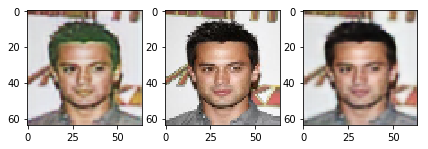

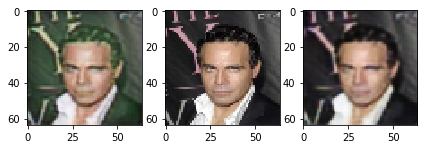

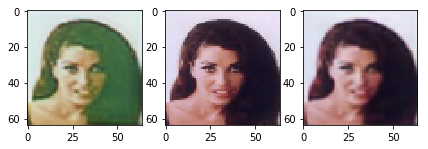

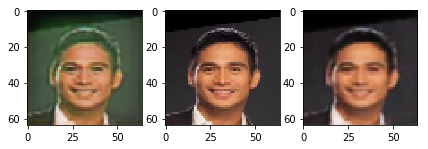

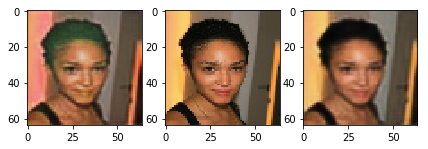

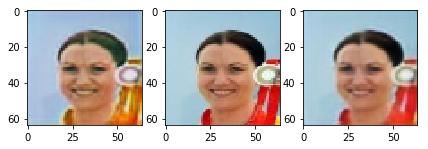

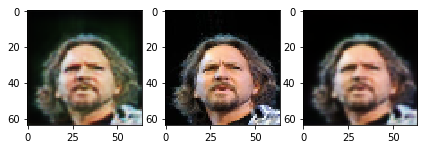

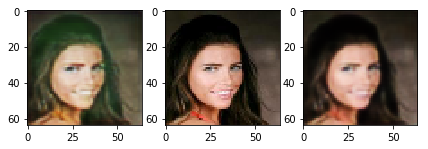

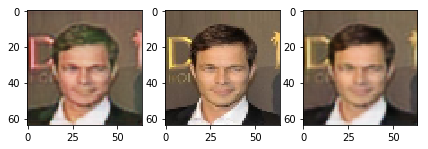

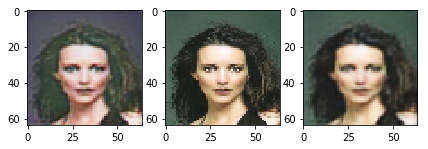

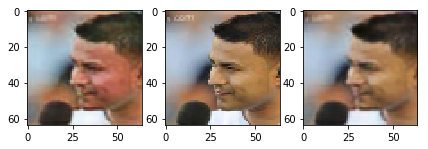

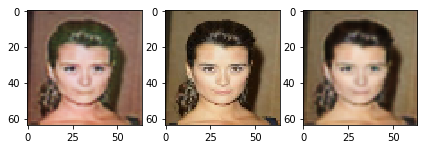

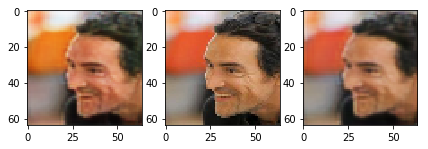

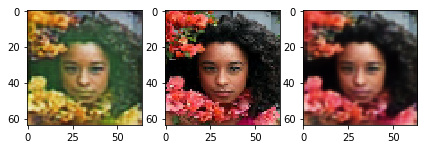

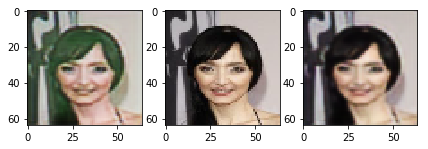

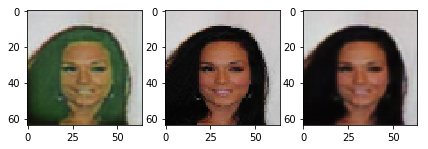

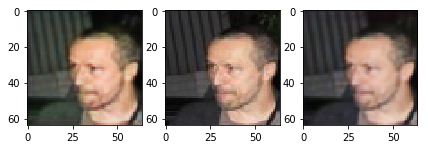

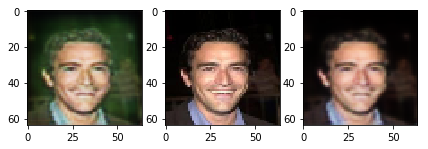

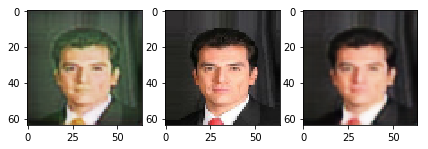

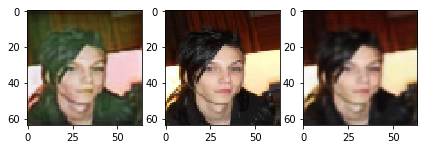

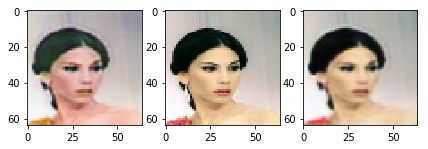

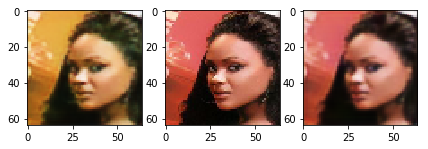

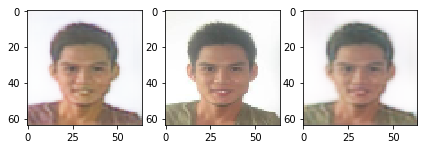

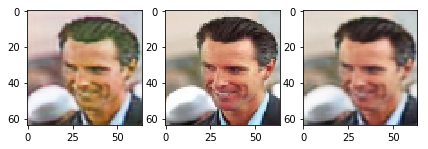

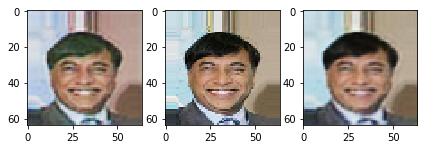

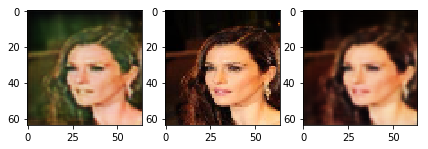

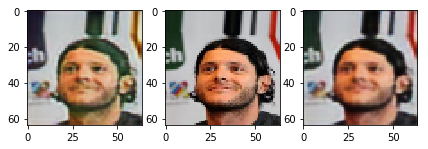

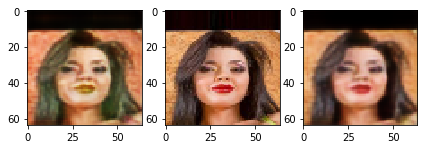

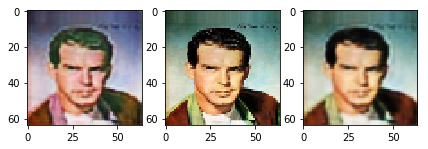

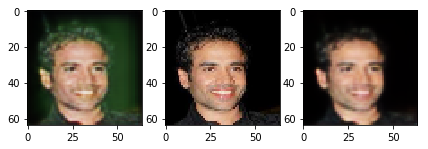

In [178]:
view(0)
view(1)
view(2)

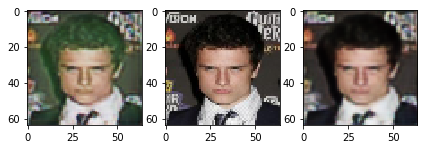

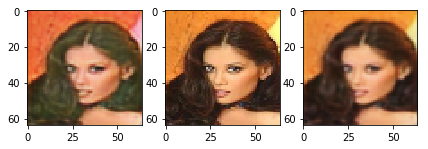

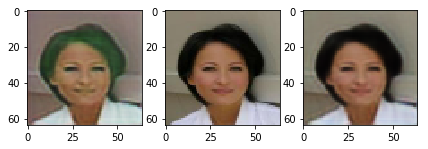

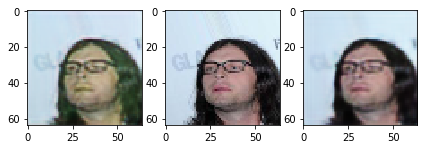

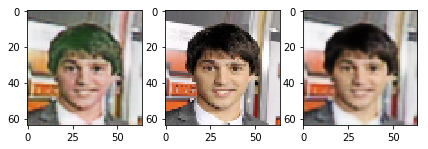

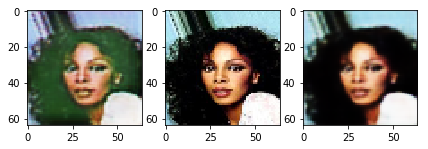

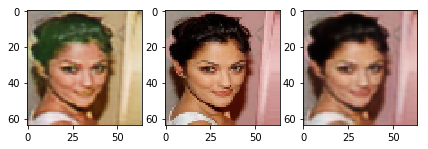

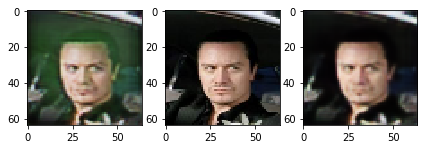

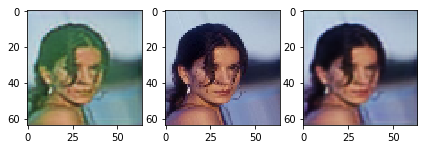

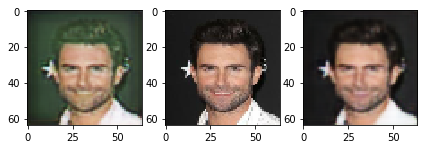

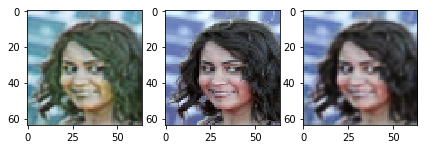

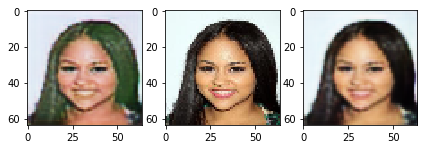

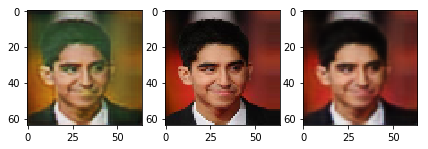

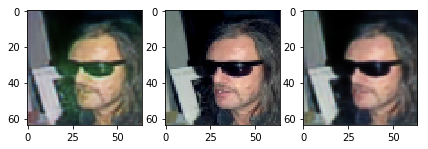

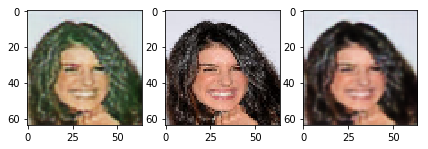

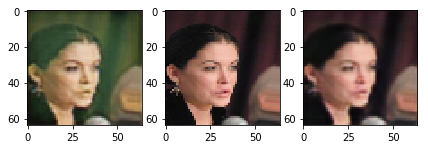

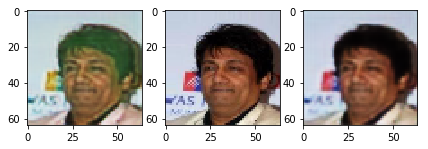

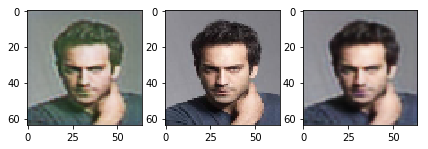

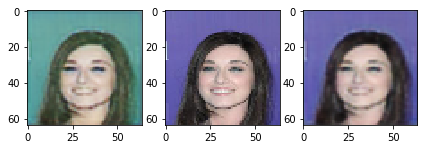

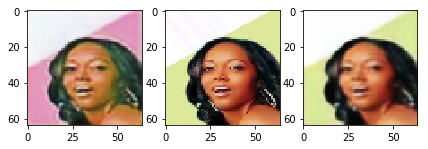

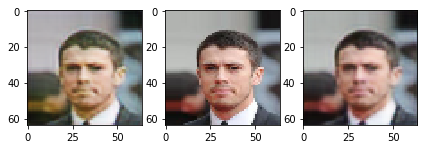

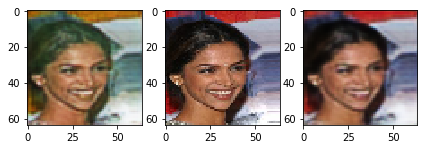

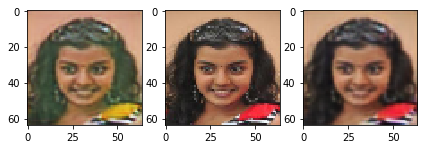

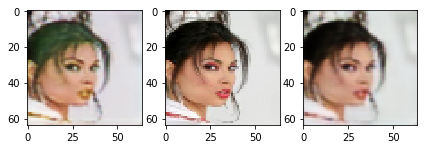

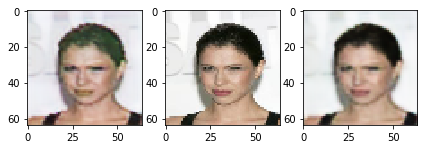

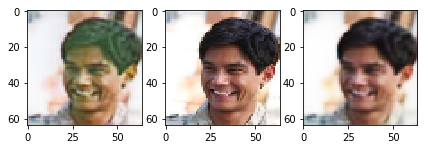

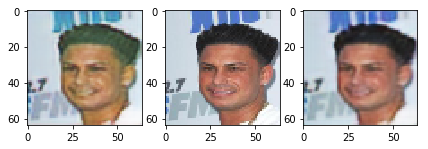

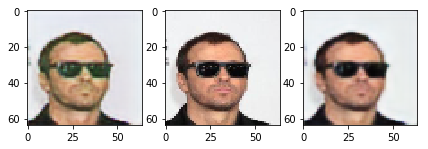

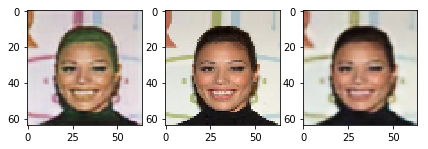

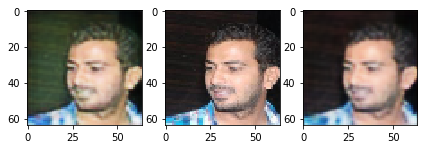

In [177]:
view(3)
view(4)
view(5)

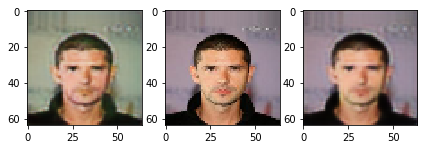

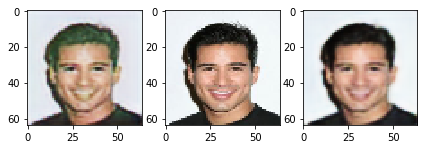

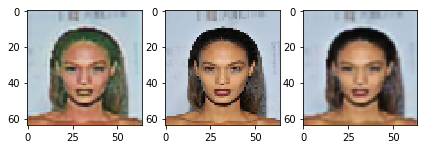

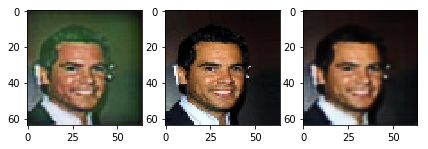

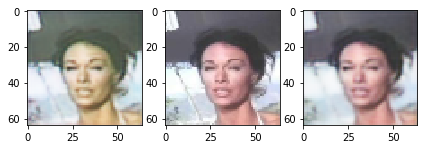

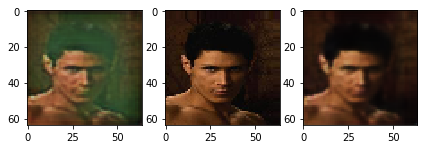

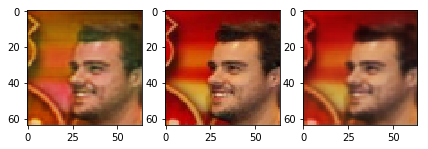

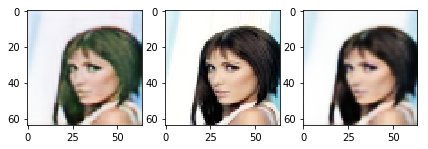

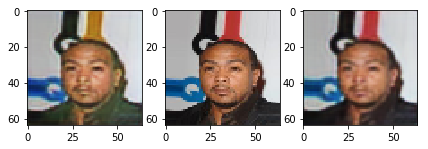

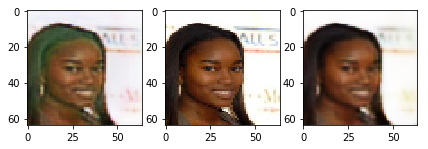

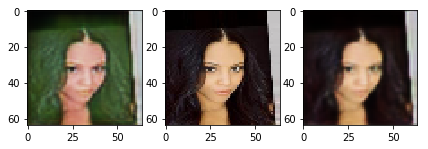

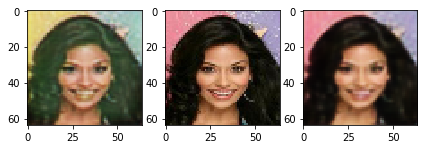

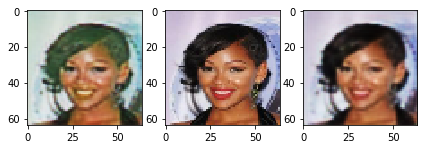

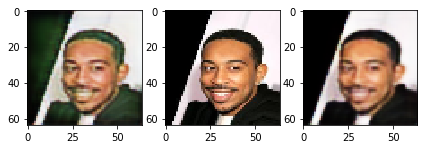

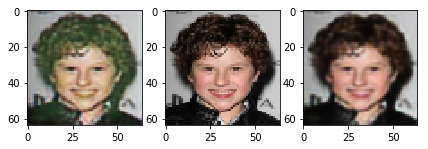

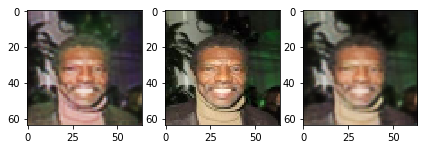

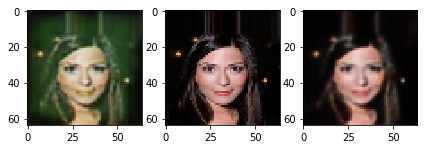

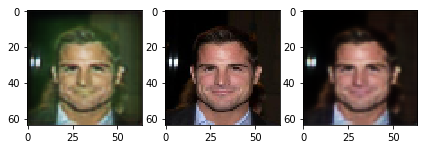

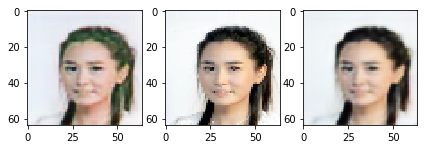

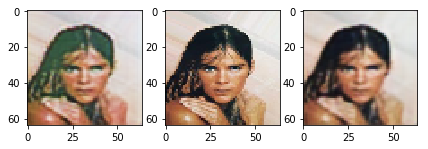

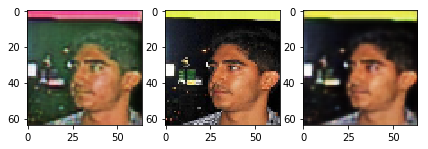

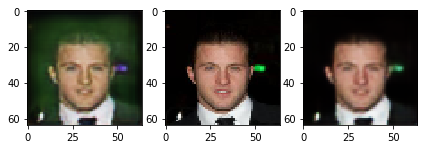

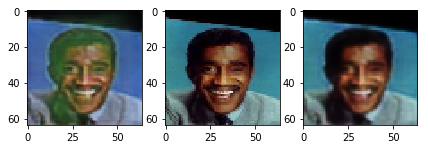

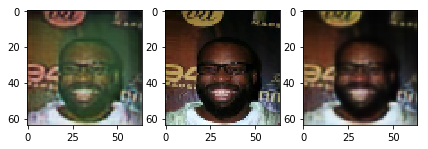

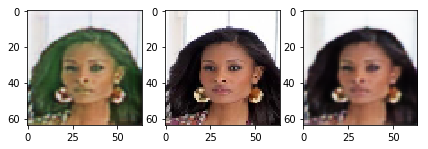

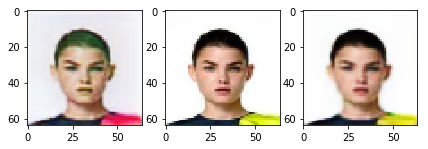

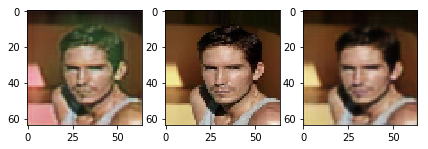

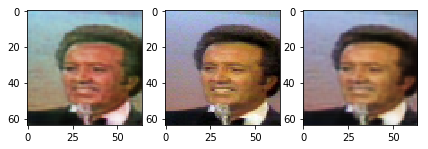

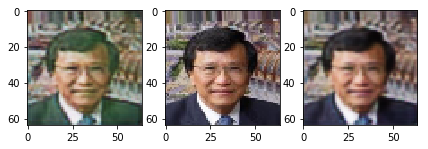

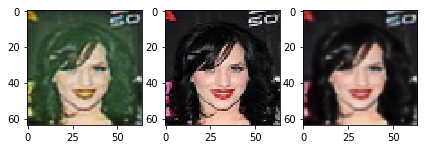

In [179]:
view(6)
view(7)
view(8)

In [34]:
import pickle
import gzip
with gzip.open('H:\\JupyterGod\\celeba\\celeba\\black_data', 'wb') as filehandle:  
    pickle.dump(Black,filehandle)
with gzip.open('H:\\JupyterGod\\celeba\\celeba\\blond_data', 'wb') as filehandle:  
    pickle.dump(Blond,filehandle)

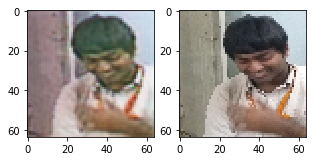

In [198]:
n=cv2.imread("H:\JupyterGod\celeba\celeba\myimgs\p12.jpg")
n=cv2.resize(n,size)
n=(n.astype('float32'))/127.5-1
m=g_AB.predict(n.reshape(1,64,64,3))
g = plt.figure(figsize=(5,5))
g.add_subplot(1,2,1)
plt.imshow(cv2.cvtColor(np.array(m[0]+1)/2, cv2.COLOR_BGR2RGB))
g.add_subplot(1,2,2)
plt.imshow(cv2.cvtColor(np.array(n+1)/2, cv2.COLOR_BGR2RGB))

In [172]:
g_AB.save("AB.h5")
g_BA.save("BA.h5")

In [173]:
d_A.save("d_A.h5")
d_B.save("d_B.h5")
model.save("model.h5")